In [1]:
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acovf,acf,pacf
from sklearn.metrics import mean_squared_error

In [2]:
store_df = pd.read_csv('data/store.csv')
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')
sample_submission_df = pd.read_csv('data/sample_submission.csv')

/scratch/7753275.1.p8/ipykernel_814799/3598239639.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('data/train.csv')


In [3]:
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [4]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [7]:
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [10]:
df = train_df.sort_values(by=['Store', 'Date']).reset_index(drop=True)
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,2013-01-01,0,0,0,0,a,1
1,2,2,2013-01-01,0,0,0,0,a,1
2,3,2,2013-01-01,0,0,0,0,a,1
3,4,2,2013-01-01,0,0,0,0,a,1
4,5,2,2013-01-01,0,0,0,0,a,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,5,2015-07-31,5723,422,1,1,0,1
1017205,1112,5,2015-07-31,9626,767,1,1,0,1
1017206,1113,5,2015-07-31,7289,720,1,1,0,1
1017207,1114,5,2015-07-31,27508,3745,1,1,0,1


## Data preprocessing

#### Checking any problems with the data

In [11]:
train_df.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

The value 0 occurs in two data types

In [12]:
train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [13]:
def one_hot_encode(df, column_name):
    one_hot_df = pd.get_dummies(df[column_name], prefix=column_name+"_", drop_first=False, dtype=int)
    new_cols = df.columns.drop(column_name)
    new_df = pd.concat([df[new_cols], one_hot_df], axis=1)
    return new_df

def preprocess_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.loc[df['StateHoliday'] == 0, 'StateHoliday'] = '0'
    df = one_hot_encode(df, 'StateHoliday')
    df = df.sort_values(by=['Store', 'Date']).reset_index(drop=True)
    # df = df.iloc[::-1].reset_index(drop=True)
    
    return df
    

In [14]:
train_df = preprocess_data(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
0,1,2,2013-01-01,0,0,0,0,1,0,1,0,0
1,1,3,2013-01-02,5530,668,1,0,1,1,0,0,0
2,1,4,2013-01-03,4327,578,1,0,1,1,0,0,0
3,1,5,2013-01-04,4486,619,1,0,1,1,0,0,0
4,1,6,2013-01-05,4997,635,1,0,1,1,0,0,0


In [15]:
test_df = preprocess_data(test_df)
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a
0,40233,1,6,2015-08-01,1.0,0,1,1,0
1,39377,1,7,2015-08-02,0.0,0,1,1,0
2,38521,1,1,2015-08-03,1.0,1,1,1,0
3,37665,1,2,2015-08-04,1.0,1,1,1,0
4,36809,1,3,2015-08-05,1.0,1,1,1,0


## Exploring the data

In [17]:
corr_df = train_df[list(train_df.columns[1:])].corr()
corr_df

,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
DayOfWeek,1.000000,0.000183,-0.462125,-0.386445,-0.528963,-0.392925,-0.205388,0.052889,-0.040981,-0.040668,-0.001345
Date,0.000183,1.000000,0.041904,0.012679,-0.000157,0.017249,0.001068,-0.003736,-0.001144,-0.000957,0.013887
Sales,-0.462125,0.041904,1.000000,0.894711,0.678472,0.452345,0.085124,0.254216,-0.203028,-0.117497,-0.092618
Customers,-0.386445,0.012679,0.894711,1.000000,0.616768,0.316169,0.071568,0.226608,-0.180900,-0.104522,-0.083007
Open,-0.528963,-0.000157,0.678472,0.616768,1.000000,0.295042,0.086171,0.378378,-0.302107,-0.175158,-0.137685
Promo,-0.392925,0.017249,0.452345,0.316169,0.295042,1.000000,0.067483,0.012353,-0.004034,0.019847,-0.049964
SchoolHoliday,-0.205388,0.001068,0.085124,0.071568,0.086171,0.067483,1.000000,-0.148651,0.029126,0.159098,0.136405
StateHoliday__0,0.052889,-0.003736,0.254216,0.226608,0.378378,0.012353,-0.148651,1.000000,-0.803389,-0.458547,-0.358514
StateHoliday__a,-0.040981,-0.001144,-0.203028,-0.180900,-0.302107,-0.004034,0.029126,-0.803389,1.000000,-0.011599,-0.009069
StateHoliday__b,-0.040668,-0.000957,-0.117497,-0.104522,-0.175158,0.019847,0.159098,-0.458547,-0.011599,1.000000,-0.005176


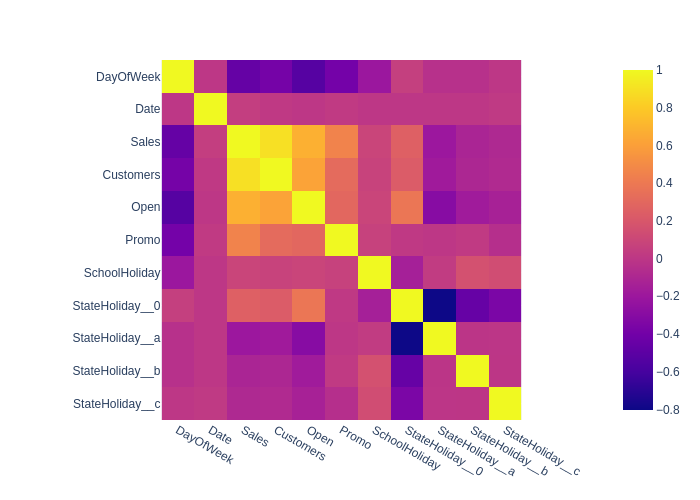

In [18]:
fig = px.imshow(corr_df)
fig.show("png")

Customers and Open columns are strongly correlated with Sales

#### Looking at the data of a random store

In [19]:
df_store_x = train_df[train_df['Store'] == 1011]
df_store_x

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
921243,1011,2,2013-01-01,0,0,0,0,1,0,1,0,0
921244,1011,3,2013-01-02,7049,900,1,0,1,1,0,0,0
921245,1011,4,2013-01-03,6377,802,1,0,1,1,0,0,0
921246,1011,5,2013-01-04,5981,793,1,0,1,1,0,0,0
921247,1011,6,2013-01-05,7963,1043,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
922180,1011,1,2015-07-27,10066,902,1,1,1,1,0,0,0
922181,1011,2,2015-07-28,8673,834,1,1,1,1,0,0,0
922182,1011,3,2015-07-29,7755,732,1,1,1,1,0,0,0
922183,1011,4,2015-07-30,9227,877,1,1,1,1,0,0,0


In [20]:
store_corr_df = train_df[list(df_store_x.columns[1:])].corr()
store_corr_df

,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
DayOfWeek,1.000000,0.000183,-0.462125,-0.386445,-0.528963,-0.392925,-0.205388,0.052889,-0.040981,-0.040668,-0.001345
Date,0.000183,1.000000,0.041904,0.012679,-0.000157,0.017249,0.001068,-0.003736,-0.001144,-0.000957,0.013887
Sales,-0.462125,0.041904,1.000000,0.894711,0.678472,0.452345,0.085124,0.254216,-0.203028,-0.117497,-0.092618
Customers,-0.386445,0.012679,0.894711,1.000000,0.616768,0.316169,0.071568,0.226608,-0.180900,-0.104522,-0.083007
Open,-0.528963,-0.000157,0.678472,0.616768,1.000000,0.295042,0.086171,0.378378,-0.302107,-0.175158,-0.137685
Promo,-0.392925,0.017249,0.452345,0.316169,0.295042,1.000000,0.067483,0.012353,-0.004034,0.019847,-0.049964
SchoolHoliday,-0.205388,0.001068,0.085124,0.071568,0.086171,0.067483,1.000000,-0.148651,0.029126,0.159098,0.136405
StateHoliday__0,0.052889,-0.003736,0.254216,0.226608,0.378378,0.012353,-0.148651,1.000000,-0.803389,-0.458547,-0.358514
StateHoliday__a,-0.040981,-0.001144,-0.203028,-0.180900,-0.302107,-0.004034,0.029126,-0.803389,1.000000,-0.011599,-0.009069
StateHoliday__b,-0.040668,-0.000957,-0.117497,-0.104522,-0.175158,0.019847,0.159098,-0.458547,-0.011599,1.000000,-0.005176


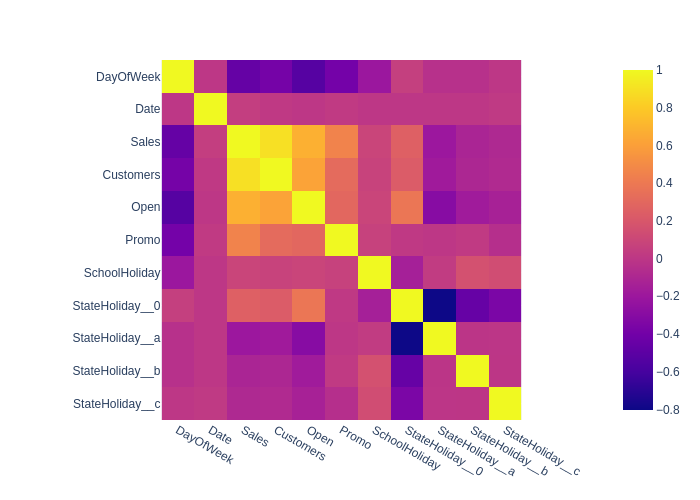

In [21]:
fig = px.imshow(store_corr_df)
fig.show("png")

Same correlation is observed for this particular store

### Trend plot

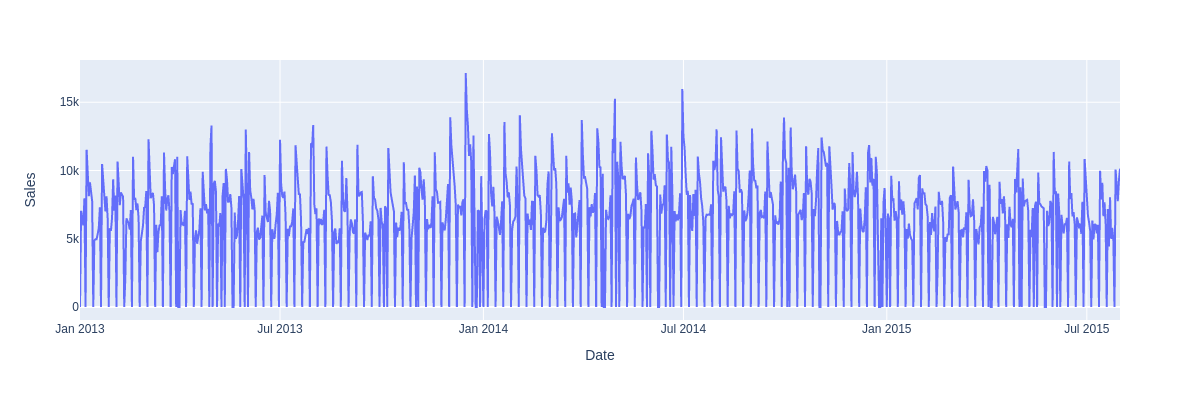

In [22]:
fig = px.line(df_store_x, x="Date", y="Sales", width=1200, height=400)
fig.show("png")

#### Exploring seasonal decomposition using moving averages.

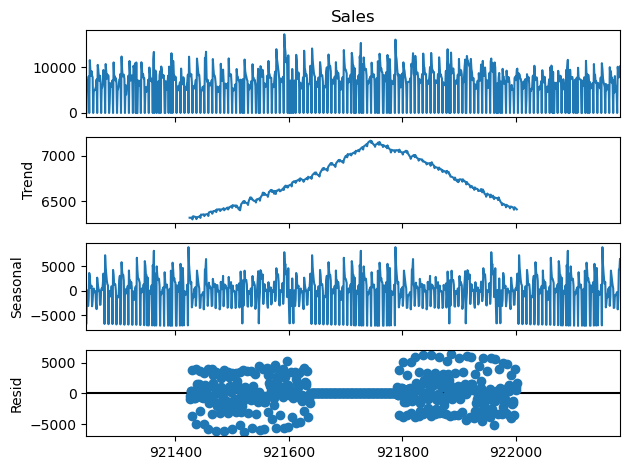

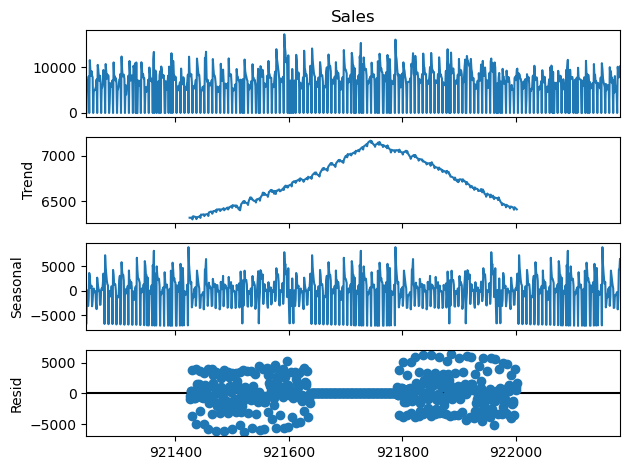

In [23]:
seasonal_decompose(df_store_x['Sales'], period=365).plot()

#### Verify stationarity assumtion 

In [24]:
adf_res = adfuller(df_store_x['Sales'])

In [25]:
labels = ['Augmented Dickey-Fuller test','p-value','number of lags used', 'no of obs', 'critical values', 'icbest']
out = pd.Series(adf_res,index=labels)

In [26]:
out

Augmented Dickey-Fuller test                                            -4.862315
p-value                                                                  0.000041
number of lags used                                                            21
no of obs                                                                     920
critical values                 {'1%': -3.4374778690219956, '5%': -2.864686684...
icbest                                                               16796.574734
dtype: object

Since p value is less than 0.05 there is string evidence that data is stationary

### ACF PACF plots

In [27]:
acf(df_store_x['Sales'], nlags=50)

array([ 1.        , -0.05640717,  0.00334498,  0.04599894, -0.02189872,
       -0.1285885 , -0.23812849,  0.48184466, -0.24852527, -0.17217988,
       -0.02619316, -0.00576241, -0.058012  , -0.09010434,  0.69873741,
       -0.09526309, -0.02886049,  0.01066504, -0.00817778, -0.10765653,
       -0.21350794,  0.53254246, -0.22436679, -0.1118264 , -0.00992994,
        0.00828895, -0.05460151, -0.1353296 ,  0.65730458, -0.10441206,
       -0.03542967,  0.00414869, -0.00487372, -0.0863739 , -0.17839469,
        0.55257595, -0.18250545, -0.09852669,  0.00636639,  0.01015266,
       -0.07489407, -0.12102585,  0.59380382, -0.14320865, -0.0599614 ,
       -0.00159797,  0.0132978 , -0.0886084 , -0.1797799 ,  0.58667622,
       -0.19708949])

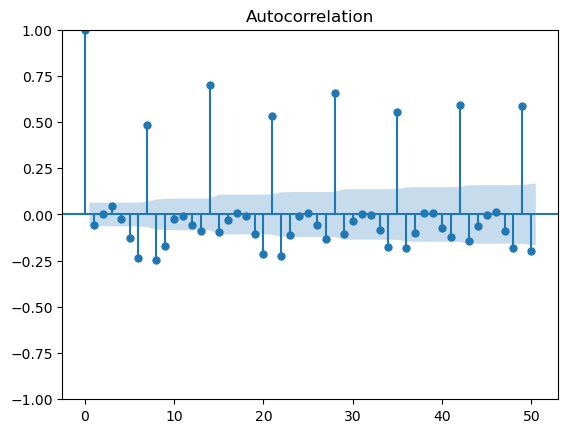

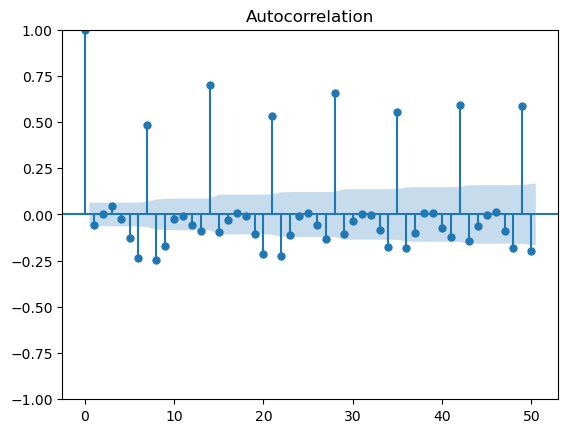

In [28]:
# plot_acf(df2,title=title,lags=lags);
plot_acf(df_store_x['Sales'], lags=50)

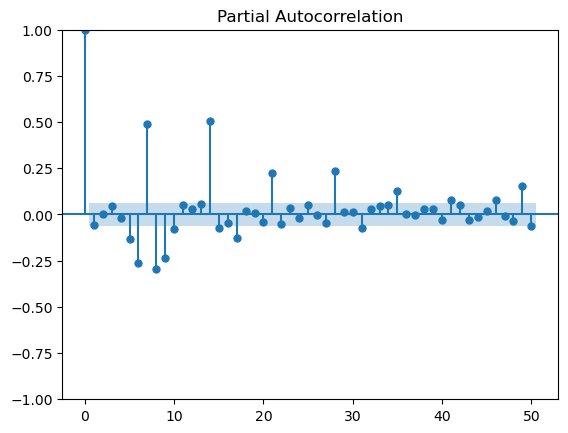

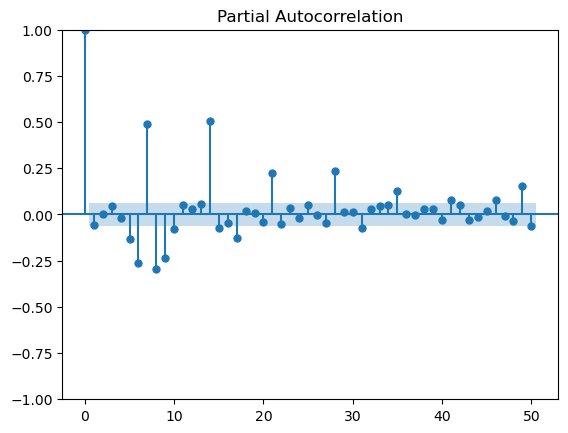

In [29]:
plot_pacf(df_store_x['Sales'], lags=50)

ACF plot reflects a 7 day seasonality 

#### Train test split 

In [30]:
store_train_df = df_store_x[:-50]
store_test_df = df_store_x[-50:]

In [31]:
store_train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
921243,1011,2,2013-01-01,0,0,0,0,1,0,1,0,0
921244,1011,3,2013-01-02,7049,900,1,0,1,1,0,0,0
921245,1011,4,2013-01-03,6377,802,1,0,1,1,0,0,0
921246,1011,5,2013-01-04,5981,793,1,0,1,1,0,0,0
921247,1011,6,2013-01-05,7963,1043,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
922130,1011,7,2015-06-07,0,0,0,0,0,1,0,0,0
922131,1011,1,2015-06-08,6748,823,1,0,0,1,0,0,0
922132,1011,2,2015-06-09,5964,729,1,0,0,1,0,0,0
922133,1011,3,2015-06-10,5386,736,1,0,0,1,0,0,0


In [33]:
store_test_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
922135,1011,5,2015-06-12,6048,708,1,0,0,1,0,0,0
922136,1011,6,2015-06-13,6531,853,1,0,0,1,0,0,0
922137,1011,7,2015-06-14,0,0,0,0,0,1,0,0,0
922138,1011,1,2015-06-15,10660,1016,1,1,0,1,0,0,0
922139,1011,2,2015-06-16,7895,854,1,1,0,1,0,0,0


In [34]:
store_test_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
922180,1011,1,2015-07-27,10066,902,1,1,1,1,0,0,0
922181,1011,2,2015-07-28,8673,834,1,1,1,1,0,0,0
922182,1011,3,2015-07-29,7755,732,1,1,1,1,0,0,0
922183,1011,4,2015-07-30,9227,877,1,1,1,1,0,0,0
922184,1011,5,2015-07-31,10134,1021,1,1,1,1,0,0,0


## SARIMA model

Running grid search to find the best parameters for SARIMA model

In [24]:
search_res = auto_arima(df_store_x['Sales'], start_p=0, start_q=0, max_p=3, max_q=8, seasonal=True, 
                        m=7, max_P=8, max_D=4, max_Q=8, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=18062.020, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=17991.450, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=17957.563, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=19461.490, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=18061.274, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=17952.404, Time=0.33 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=18020.764, Time=0.11 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=17643.569, Time=1.04 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=17953.702, Time=0.53 sec
 ARIMA(0,0,1)(3,0,1)[7] intercept   : AIC=inf, Time=3.61 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=17637.897, Time=2.66 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=17758.400, Time=1.09 sec
 ARIMA(0,0,1)(3,0,2)[7] intercept   : AIC=inf, Time=4.46 sec
 ARIMA(0,0,1)(2,0,3)[7] intercept   :

In [25]:
search_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                SARIMAX Results                                                 
================================================================================================================
Dep. Variable:                                                        y   No. Observations:                  942
Model:             SARIMAX(0, 0, 3)x(0, 0, [1, 2, 3, 4, 5, 6, 7, 8], 7)   Log Likelihood               -8653.117
Date:                                                  Sat, 01 Jun 2024   AIC                          17332.235
Time:                                                          23:12:27   BIC                          17395.259
Sample:                                                               0   HQIC                         17356.258
                                                                  - 942                                         
Covariance Type:                                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6483.2172    346.935     18.687      0.000    5803.236    7163.198
ma.L1          0.1193      0.024      4.952      0.000       0.072       0.167
ma.L2          0.1521      0.033      4.606      0.000       0.087       0.217
ma.L3          0.1474      0.026      5.708      0.000       0.097       0.198
ma.S.L7        0.1140      0.030      3.776      0.000       0.055       0.173
ma.S.L14       0.4530      0.027     16.677      0.000       0.400       0.506
ma.S.L21       0.2192      0.032      6.927      0.000       0.157       0.281
ma.S.L28       0.4419      0.030     14.691      0.000       0.383       0.501
ma.S.L35       0.2061      0.033      6.184      0.000       0.141       0.271
ma.S.L42       0.2753      0.032      8.543      0.000       0.212       0.338
ma.S.L49       0.2405      0.030      7.949      0.000       0.181       0.300
ma.S.L56       0.1726      0.035      4.911      0.000       0.104       0.241
sigma2      5.518e+06   1.98e+05     27.902      0.000    5.13e+06    5.91e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               188.03
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.45
Prob(H) (two-sided):                  0.22   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
sarima = SARIMAX(store_train_df['Sales'], order=(0, 0, 3), seasonal_order=(0, 0, 8, 7))
sarima_model = sarima.fit()
sarima_model.summary()

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.93876D+00    |proj g|=  1.69694D-01

At iterate    5    f=  9.88790D+00    |proj g|=  3.39544D-04

At iterate   10    f=  9.88790D+00    |proj g|=  4.10515D-04

At iterate   15    f=  9.88766D+00    |proj g|=  6.58437D-03

At iterate   20    f=  9.85739D+00    |proj g|=  9.60829D-02

At iterate   25    f=  9.34444D+00    |proj g|=  1.05978D-01

At iterate   30    f=  9.29958D+00    |proj g|=  2.87754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                SARIMAX Results                                                 
================================================================================================================
Dep. Variable:                                                    Sales   No. Observations:                  892
Model:             SARIMAX(0, 0, 3)x(0, 0, [1, 2, 3, 4, 5, 6, 7, 8], 7)   Log Likelihood               -8295.220
Date:                                                  Mon, 03 Jun 2024   AIC                          16614.440
Time:                                                          09:18:31   BIC                          16671.961
Sample:                                                               0   HQIC                         16636.423
                                                                  - 892                                         
Covariance Type:                                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2799      0.026     10.650      0.000       0.228       0.331
ma.L2          0.2813      0.033      8.492      0.000       0.216       0.346
ma.L3          0.2361      0.030      7.969      0.000       0.178       0.294
ma.S.L7        0.2714      0.031      8.778      0.000       0.211       0.332
ma.S.L14       0.5623      0.028     20.025      0.000       0.507       0.617
ma.S.L21       0.3988      0.036     11.200      0.000       0.329       0.469
ma.S.L28       0.5593      0.035     16.094      0.000       0.491       0.627
ma.S.L35       0.3607      0.039      9.350      0.000       0.285       0.436
ma.S.L42       0.3683      0.033     11.205      0.000       0.304       0.433
ma.S.L49       0.3503      0.033     10.536      0.000       0.285       0.416
ma.S.L56       0.1964      0.031      6.315      0.000       0.135       0.257
sigma2      6.887e+06   2.75e+05     25.065      0.000    6.35e+06    7.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   8.77   Jarque-Bera (JB):               240.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.38
Prob(H) (two-sided):                  0.29   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
start = len(store_train_df)
end = start + len(store_test_df) - 1
sarima_forecast = sarima_model.predict(start=start, end=end)

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [37]:
forecast_df = store_test_df[['Store', 'Date', 'Sales']].copy()
forecast_df['SarimaForecast'] = np.array(sarima_forecast)
forecast_df.head()

,Store,Date,Sales,SarimaForecast
922135,1011,2015-06-12,6048,7826.453616
922136,1011,2015-06-13,6531,6451.905214
922137,1011,2015-06-14,0,929.493840
922138,1011,2015-06-15,10660,6861.623832
922139,1011,2015-06-16,7895,5719.771558


## SARIMAX model (with exogenous)

In [38]:
df_store_x.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StateHoliday__0', 'StateHoliday__a',
       'StateHoliday__b', 'StateHoliday__c'],
      dtype='object')

In [39]:
exog_cols = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday__0', 'StateHoliday__a',
       'StateHoliday__b', 'StateHoliday__c']
exog = df_store_x[exog_cols].to_numpy()
print(exog.shape)
exog


(942, 8)


array([[2, 0, 0, ..., 1, 0, 0],
       [3, 1, 0, ..., 0, 0, 0],
       [4, 1, 0, ..., 0, 0, 0],
       ...,
       [3, 1, 1, ..., 0, 0, 0],
       [4, 1, 1, ..., 0, 0, 0],
       [5, 1, 1, ..., 0, 0, 0]])

In [40]:
search_res = auto_arima(df_store_x['Sales'], exog, start_p=0, start_q=0, max_p=3, max_q=8, seasonal=True, 
                        m=7, max_P=8, max_D=4, max_Q=8, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=16438.801, Time=3.71 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=16570.010, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=16469.244, Time=0.57 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=16396.040, Time=1.99 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=16568.013, Time=1.39 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=16382.220, Time=2.47 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=16394.271, Time=2.41 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.56 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=16262.087, Time=2.98 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=16255.454, Time=4.24 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=16143.847, Time=5.68 sec
 ARIMA(1,1,1)(3,0,0)[7] intercept   : AIC=inf, Time=12.85 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=6.47 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=4.88 sec
 ARIMA(1,1,1)(3,0,1)[7] intercept   : AIC=

In [41]:
search_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  942
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 7)   Log Likelihood               -8053.586
Date:                            Mon, 03 Jun 2024   AIC                          16137.172
Time:                                    09:21:50   BIC                          16209.876
Sample:                                         0   HQIC                         16164.886
                                            - 942                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0121      0.508      0.024      0.981      -0.983       1.007
x1           -49.2627     56.836     -0.867      0.386    -160.660      62.134
x2          7556.9312    469.353     16.101      0.000    6637.015    8476.847
x3          1957.0934    145.640     13.438      0.000    1671.644    2242.542
x4          -188.6820    143.935     -1.311      0.190    -470.789      93.425
x5           229.0577   2334.289      0.098      0.922   -4346.065    4804.181
x6         -1101.3933   2252.544     -0.489      0.625   -5516.298    3313.511
x7         -1413.8127   2276.872     -0.621      0.535   -5876.399    3048.774
x8          2285.7393   2370.800      0.964      0.335   -2360.942    6932.421
ar.L1          0.5722      0.071      8.088      0.000       0.434       0.711
ma.L1         -1.1795      0.075    -15.633      0.000      -1.327      -1.032
ma.L2          0.1884      0.073      2.576      0.010       0.045       0.332
ar.S.L7        0.0731      0.028      2.617      0.009       0.018       0.128
ar.S.L14       0.3564      0.024     14.728      0.000       0.309       0.404
sigma2      1.578e+06   4.85e+04     32.546      0.000    1.48e+06    1.67e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               441.15
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.40
Prob(H) (two-sided):                  0.18   Kurtosis:                         6.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
sarimax = SARIMAX(store_train_df['Sales'], exog=store_train_df[exog_cols], order=(1, 1, 2), seasonal_order=(2, 0, 0, 7))
sarimax_model = sarimax.fit()
sarimax_model.summary()

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60400D+00    |proj g|=  5.44728D-02

At iterate    5    f=  8.59481D+00    |proj g|=  1.92348D-02

At iterate   10    f=  8.57624D+00    |proj g|=  5.59253D-03

At iterate   15    f=  8.57477D+00    |proj g|=  4.94966D-04

At iterate   20    f=  8.57476D+00    |proj g|=  2.31032D-04

At iterate   25    f=  8.57473D+00    |proj g|=  2.60238D-03

At iterate   30    f=  8.57180D+00    |proj g|=  1.10457D-02

At iterate   35    f=  8.55874D+00    |proj g|=  2.19648D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  892
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 7)   Log Likelihood               -7634.391
Date:                            Mon, 03 Jun 2024   AIC                          15296.781
Time:                                    09:23:17   BIC                          15363.874
Sample:                                         0   HQIC                         15322.423
                                            - 892                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
DayOfWeek         -33.6513     60.465     -0.557      0.578    -152.160      84.858
Open             7652.6695    493.855     15.496      0.000    6684.731    8620.608
Promo            1959.4282    151.417     12.941      0.000    1662.657    2256.200
SchoolHoliday    -158.7711    149.782     -1.060      0.289    -452.339     134.797
StateHoliday__0   162.3193   2346.144      0.069      0.945   -4436.038    4760.676
StateHoliday__a -1072.2034   2248.063     -0.477      0.633   -5478.325    3333.918
StateHoliday__b -1398.1948   2276.622     -0.614      0.539   -5860.292    3063.902
StateHoliday__c  2307.6273   2383.474      0.968      0.333   -2363.896    6979.151
ar.L1               0.6257      0.060     10.409      0.000       0.508       0.743
ma.L1              -1.2362      0.069    -17.788      0.000      -1.372      -1.100
ma.L2               0.2365      0.066      3.570      0.000       0.107       0.366
ar.S.L7             0.0815      0.028      2.890      0.004       0.026       0.137
ar.S.L14            0.3656      0.023     16.030      0.000       0.321       0.410
sigma2           1.594e+06   5.29e+04     30.151      0.000    1.49e+06     1.7e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               440.11
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.42
Prob(H) (two-sided):                  0.21   Kurtosis:                         6.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
start = len(store_train_df)
end = start + len(store_test_df) - 1
sarimax_forecast = sarimax_model.predict(start=start, end=end, exog=store_test_df[exog_cols])

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [45]:
store_test_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
922135,1011,5,2015-06-12,6048,708,1,0,0,1,0,0,0
922136,1011,6,2015-06-13,6531,853,1,0,0,1,0,0,0
922137,1011,7,2015-06-14,0,0,0,0,0,1,0,0,0
922138,1011,1,2015-06-15,10660,1016,1,1,0,1,0,0,0
922139,1011,2,2015-06-16,7895,854,1,1,0,1,0,0,0


In [46]:
# forecast_df = store_test_df[['Store', 'Date', 'Sales']].copy()
forecast_df['SarimaxForecast'] = np.array(sarimax_forecast)
forecast_df.head()

,Store,Date,Sales,SarimaForecast,SarimaxForecast
922135,1011,2015-06-12,6048,7826.453616,6868.667424
922136,1011,2015-06-13,6531,6451.905214,6985.494969
922137,1011,2015-06-14,0,929.493840,-489.510929
922138,1011,2015-06-15,10660,6861.623832,9865.396821
922139,1011,2015-06-16,7895,5719.771558,8699.963379


In [47]:
forecast_df.tail()

,Store,Date,Sales,SarimaForecast,SarimaxForecast
922180,1011,2015-07-27,10066,2013.426036,9110.056190
922181,1011,2015-07-28,8673,1104.313806,9005.857587
922182,1011,2015-07-29,7755,1122.678231,8968.908454
922183,1011,2015-07-30,9227,891.132225,8956.657735
922184,1011,2015-07-31,10134,451.565945,8927.047608


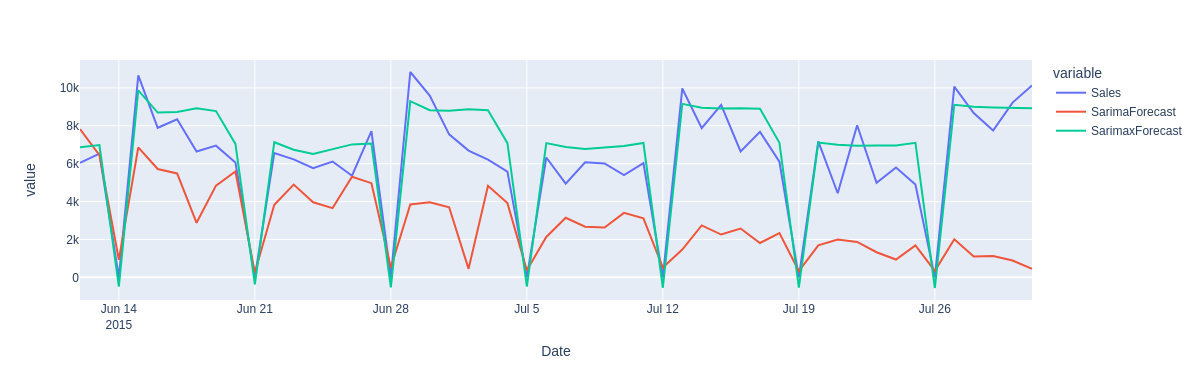

In [48]:
fig = px.line(forecast_df, x="Date", y=["Sales", "SarimaForecast", "SarimaxForecast"], width=1200, height=380)
fig.show("png")

In [49]:
sarima_rmse = np.sqrt(mean_squared_error(forecast_df['Sales'], forecast_df['SarimaForecast']))
sarimax_rmse = np.sqrt(mean_squared_error(forecast_df['Sales'], forecast_df['SarimaxForecast']))
print("sarima_rmse: ", sarima_rmse)
print("sarimax_rmse: ", sarimax_rmse)

sarima_rmse:  4321.817841389038
sarimax_rmse:  1241.4548739223058


## Conclusion

The SARIMAX model with exogenous variables is performing significantly better. The correlation plots show that sales data is related to the Customer, Close, and Open columns, so it makes sense that the model's performance has improved after including this data.
